# Import Important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from tqdm.notebook import tqdm_notebook
import warnings 
warnings.filterwarnings('ignore')

# using GPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("number of GPUs found ",len(physical_devices))
print('\n Loaded on GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

number of GPUs found  1

 Loaded on GPU


# The training data

In [3]:
train_df = pd.read_csv('train.csv')
train_df = train_df.reset_index(drop=True)

# Looking for label distribution

In [4]:
print('Unique labels in train set :\n\n',train_df.label.unique())

Unique labels in train set :

 ['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']


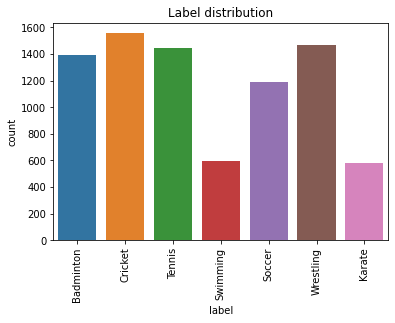

In [5]:
sns.countplot(train_df['label'])
plt.title('Label distribution')
plt.xticks(rotation='vertical')
plt.show()

# Dividing the data into train and valid set
The valid set is 25% of total training data

In [6]:
train, valid = train_test_split(train_df, random_state=42, test_size=0.25, stratify=train_df['label'])

# The model
1. Using mobilenetV2 as the base model i.e. feature extractor
2. Using custom fully connected layer for classification

In [7]:
def classifier():
    input_layer = Input(shape = (224,224,3))
    base = MobileNetV2(input_shape = (224,224,3), weights = 'imagenet', include_top = False)(input_layer)
    output = GlobalAveragePooling2D()(base)
    output = Dense(1024, activation = 'relu')(output)
    output = Dropout(0.25)(output)
    output = Dense(1024, activation = 'relu')(output)
    output = Dropout(0.25)(output)
    output = Dense(7, activation = 'softmax')(output)
    
    model = Model(input_layer, output)
    
    return model

# Dataset
1. Using ImageDataGenerator of keras for dataset generation from dataframe
2. Augmenting the data and resizing to (224,224,3)
3. The batch size is 25 (used to utilize the full capacity of my GPU)

In [8]:
batch_size = 25

datagen = ImageDataGenerator(rescale = (1/255.0),
                            horizontal_flip=True,
                            rotation_range = 60,
                            width_shift_range = 0.3, height_shift_range = 0.3,
                            brightness_range = [0.5,1.5],
                            zoom_range=0.5)

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                             directory = './train',
                                             x_col = 'image_ID',
                                             y_col = 'label',
                                             batch_size = batch_size,
                                             shuffle = True,
                                             seed = 42,
                                             target_size = (224,224),
                                             class_mode="categorical")

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                             directory = './train',
                                             x_col = 'image_ID',
                                             y_col = 'label',
                                             batch_size = batch_size,
                                             shuffle = False,
                                             seed = 42,
                                             target_size = (224,224),
                                            class_mode = "categorical")

Found 6170 validated image filenames belonging to 7 classes.
Found 2057 validated image filenames belonging to 7 classes.


In [11]:
print(f'Dictionary created by generator \n{valid_generator.class_indices}')

Dictionary created by generator 
{'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}


# Callbacks
1. earlystopper - for early stopping with patience parameter of 10
2. reduce_lr - It reduces learning rate when loss plateaus i.e. stops improving
3. checkpointer - to save best model weights

In [ ]:
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                           verbose=1, mode='max', min_lr=0.00001)

checkpointer = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

train_steps = train.shape[0]//batch_size
valid_step = valid.shape[0]//batch_size

model = classifier()

# Function to measure f1 score at each epoch

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Compiling
1. To inculcate the custom f1 claculation function in metric

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

# Training the model

In [ ]:
history = model.fit(train_generator,
                  validation_data = valid_generator,
                 epochs=150,steps_per_epoch = train_steps,
                 validation_steps = valid_step,
                 callbacks = [earlystopper, checkpointer, reduce_lr])

# Re-Compiling
1. We had a custom parameter i.e. f1 score
2. Now the weights have to be saved and we need to write the whole function to create model while testing
3. We recompile by removing the custom functions and hence can now save the model directly

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.save('sports.h5')